In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# get all normal useragents data
def get_all_normaluseragents_df(count : int = 100):
    df_firefox = pd.read_csv("data_collection/firefox.csv")
    df_chrome = pd.read_csv("data_collection/chrome.csv")
    df_ie = pd.read_csv("data_collection/internet-explorer.csv")
    df_opera = pd.read_csv("data_collection/opera.csv")
    df_safari = pd.read_csv("data_collection/safari.csv")
    df_android = pd.read_csv("data_collection/android-browser.csv")

    df_firefox.drop(["version","commonality"],axis=1,inplace=True)
    df_chrome.drop(["version","commonality"],axis=1,inplace=True)
    df_ie.drop(["version","commonality"],axis=1,inplace=True)
    df_opera.drop(["version","commonality"],axis=1,inplace=True)
    df_safari.drop(["version","commonality"],axis=1,inplace=True)
    df_android.drop(["version","commonality"],axis=1,inplace=True)

    firefox_ua =  df_firefox.head(count)
    chrome_ua =  df_chrome.head(count)
    ie_ua =  df_ie.head(count)
    safari_ua =  df_safari.head(count)
    android_ua =  df_android.head(count)

    useragents = pd.concat([firefox_ua , chrome_ua , ie_ua , safari_ua , android_ua] , axis=0)
    shuffled_ua = useragents.sample(frac=1).reset_index(drop=True)
    shuffled_ua['is_badua'] = 0
    return shuffled_ua

In [3]:
def get_all_useragents_df():
    normal_ua = get_all_normaluseragents_df(200)
    bad_ua = pd.read_csv("bad_user_agents.csv",dtype={'is_badua': 'Int64'})
    df_useragents = pd.concat([normal_ua , bad_ua],axis=0)
    df_useragents = df_useragents.sample(frac=1).reset_index(drop=True)
    return df_useragents

In [4]:
#describing user agent data frame

pd.set_option('display.max_colwidth',80)
df_useragents = get_all_useragents_df()
df_useragents.head
df_useragents.groupby("is_badua").describe()

ua         \
         count unique   
is_badua                
0         1000   1000   
1          637    634   

                                                                                           \
                                                                                      top   
is_badua                                                                                    
0         Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; Trident/7.0; SLCC2; Media...   
1                                                                             meanpathbot   

               
         freq  
is_badua       
0           1  
1           2

<Axes: xlabel='is_badua', ylabel='count'>

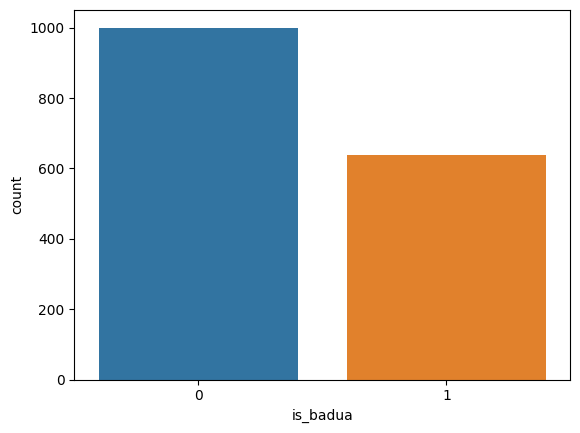

In [5]:
sns.countplot(x="is_badua" , data=df_useragents )
# df_useragents['ua'][3]

In [6]:
import sys 
sys.path.append('/Users/kisho/Documents/GitHub/Risk_Quantification')
sys.path
from WAF.utils.util import process_ua 

process_ua

<function WAF.utils.util.process_ua(ua: str)>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
#save the model
import joblib

def dump(model , filename):
    with open(filename, "wb") as f:
        joblib.dump(model , f)

X = df_useragents["ua"]
y = df_useragents['is_badua'].astype('int')

x_train , x_test , y_train , y_test = train_test_split(X ,y , test_size=0.2) 


from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer=process_ua)




In [9]:
from sklearn.pipeline import Pipeline

clf1 = RandomForestClassifier(n_estimators=30, max_depth=5)
clf2 = DecisionTreeClassifier(max_depth=10)
clf3 = KNeighborsClassifier(n_neighbors=100)

ensemble_cv_pipe = Pipeline([("count-vectorizer" ,cv ), ("VotingClassifier" ,VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2), ('clf3', clf3)], voting='soft')) ])

ensemble_cv_pipe.fit(x_train,y_train)

file_path = "C:/Users/kisho/Documents/GitHub/Risk_Quantification/WAF_Models/User_Agent_Models"
dump(ensemble_cv_pipe , filename=f"{file_path}/ens_cv_pipe.pkl")
y_ens = ensemble_cv_pipe.predict(x_test)


print("[+] ACCURACY \n")

print("Ensembled Classifier : " , accuracy_score(y_test , y_ens))



[+] ACCURACY 

Ensembled Classifier :  0.9969512195121951


In [10]:
from sklearn.metrics import classification_report


print("\nEnsembled Classifier : \n" , classification_report(y_test , y_ens))



Ensembled Classifier : 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       196
           1       0.99      1.00      1.00       132

    accuracy                           1.00       328
   macro avg       1.00      1.00      1.00       328
weighted avg       1.00      1.00      1.00       328



In [11]:
from sklearn.metrics import confusion_matrix
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
print("Confusion Matrix")


print("\nEnsembled Classifier : \n" , confusion_matrix(y_test , y_ens))


Confusion Matrix

Ensembled Classifier : 
 [[195   1]
 [  0 132]]
